## Monocle3 R

In [1]:
suppressMessages(library(rhdf5))
suppressMessages(library(monocle3))

In [2]:
ROOT.DIR <- getwd()
DATA.PATH <- file.path(ROOT.DIR, "data", "processed_data.h5")

#### Preparing monocle3 data object

In [3]:
# Read matrix
barcodes <- h5read(DATA.PATH, "expression_matrix/barcodes")
features <- h5read(DATA.PATH, "expression_matrix/features")
data <- h5read(DATA.PATH, "expression_matrix/data")
indices <- h5read(DATA.PATH, "expression_matrix/indices")
indptr <- h5read(DATA.PATH, "expression_matrix/indptr")

expr.mtx <- Matrix::sparseMatrix(
  i=indices, p=indptr, x=as.numeric(data),
  dimnames=list(as.character(features), as.character(barcodes)),
  index1=FALSE, repr="C")

# Read parameters
umap <- t(h5read(DATA.PATH, "UMAP"))
louvain <- h5read(DATA.PATH, "Louvain")

# Create cell_data_set
cds <- new_cell_data_set(expr.mtx)
rownames(cds@colData) <- barcodes

# UMAP
rownames(umap) <- barcodes
colnames(umap) <- c("umap_1", "umap_2")
cds@int_colData@listData$reducedDims@listData[["UMAP"]] <- umap

## Use 1 partition for all cells
recreate.partitions <- c(rep(1, length(cds@colData@rownames)))
names(recreate.partitions) <- cds@colData@rownames
recreate.partitions <- as.factor(recreate.partitions)
cds@clusters@listData[["UMAP"]][["partitions"]] <- recreate.partitions

## Clusters
names(louvain) <- cds@colData@rownames
louvain <- as.factor(louvain)
cds@clusters@listData[["UMAP"]][["clusters"]] <- louvain

Warning message in new_cell_data_set(expr.mtx):
“gene_metadata must contain a column verbatim named 'gene_short_name' for certain functions.”
Warning message in log(cell_total):
“NaNs produced”


#### Learn the trajectory graph

In [4]:
cds <- learn_graph(cds)

#### Pseudotime

In [5]:
cds <- order_cells(
  cds, reduction_method = "UMAP",
  root_cells = barcodes[1]
)

#### Plot trajectory graph

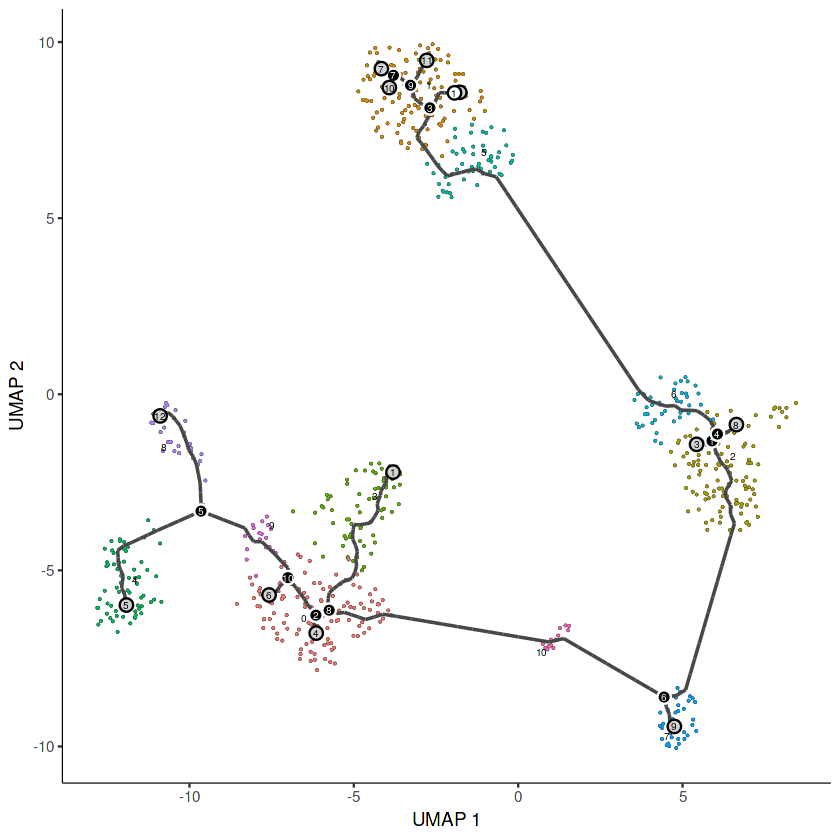

In [6]:
plot_cells(cds,
           reduction_method = "UMAP",
           color_cells_by = "cluster",
           label_groups_by_cluster=TRUE,
           label_leaves=TRUE,
           label_branch_points=TRUE)

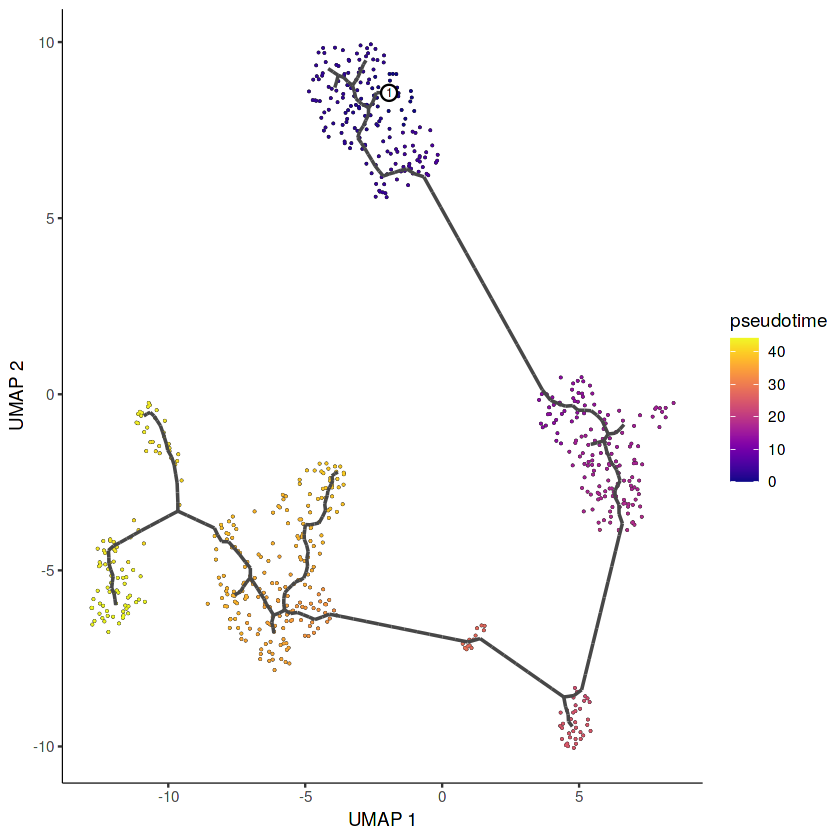

In [7]:
plot_cells(cds,
           color_cells_by = "pseudotime",
           label_cell_groups=F,
           label_leaves=F,
           label_branch_points=F,
           graph_label_size=2.5)

In [ ]:
# Writing results to comparison
principal_graph_aux <- cds@principal_graph_aux[["UMAP"]]
h5write(pseudotime(cds), file=DATA.PATH, name="pseudotime")
h5write(
  principal_graph_aux$pr_graph_cell_proj_dist,
  file=DATA.PATH, name="projected_points"
)
h5write(
  principal_graph_aux$dp_mst,
  file=DATA.PATH, name="centroids"
)